In [152]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

In [153]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

education_df = pd.read_sql_query('select * from useducation', con = engine)

engine.dispose()

In [154]:
# Since the data is a time series data, the missing values are filled in by way of interpolation. 

In [155]:
fill_list = ["STATE_REVENUE", "LOCAL_REVENUE", "TOTAL_EXPENDITURE", "INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE",
             "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE", "GRADES_PK_G", "GRADES_KG_G", "GRADES_4_G", "GRADES_8_G", 
             "GRADES_12_G", "GRADES_1_8_G", "GRADES_9_12_G", "GRADES_ALL_G"]
             
states = education_df["STATE"].unique()
             
for state in states:
    education_df.loc[education_df["STATE"] == state, fill_list] = education_df.loc[education_df["STATE"] == state, 
    fill_list].interpolate()         

education_df.dropna(inplace = True)    

# 1) Consider the two variables: TOTAL_REVENUE and TOTAL_EXPENDITURE. Do these variables have outlier values?

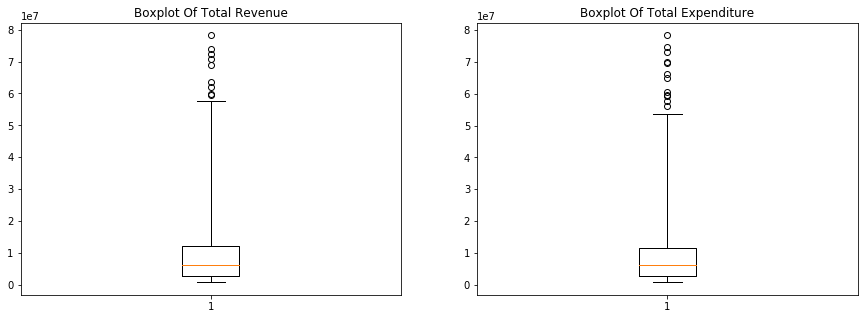

In [156]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(education_df["TOTAL_REVENUE"], whis = 5)
plt.title("Boxplot Of Total Revenue")

plt.subplot(1,2,2)
plt.boxplot(education_df["TOTAL_EXPENDITURE"], whis = 5)
plt.title("Boxplot Of Total Expenditure")
plt.show()

In [157]:
# Both variables have outlier values as seen from the boxplots.

# 2) If you detect outliers in the TOTAL_REVENUE and TOTAL_EXPENDITURE variables, apply the techniques you learned in this checkpoint to eliminate them and validate that there's no outlier values after you handled them. 

In [158]:
# Winsorization will be used to eliminate the outliers and create two new variables named winsorized_expenditure and 
# winsorized_revenue for the winsorized variants.

In [159]:
from scipy.stats.mstats import winsorize

winsorized_revenue = winsorize(education_df["TOTAL_REVENUE"], (0, 0.05))

winsorized_expenditure = winsorize(education_df["TOTAL_EXPENDITURE"], (0, 0.05))

In [160]:
# The outliers must be checked to see whether or not they are eliminated.

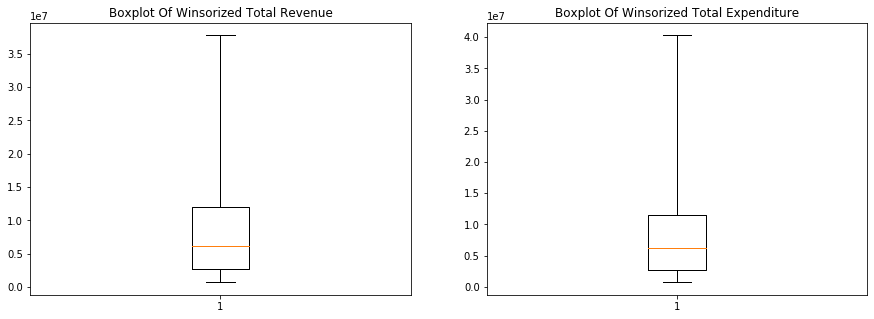

In [161]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(winsorized_revenue, whis = 5)
plt.title("Boxplot Of Winsorized Total Revenue")

plt.subplot(1,2,2)
plt.boxplot(winsorized_expenditure, whis = 5)
plt.title("Boxplot Of Winsorized Total Expenditure")
plt.show()

In [162]:
# It looks like all the outliers have been eliminated after the winsorization.

# 3) Create another variable by subtracting the original TOTAL_EXPENDITURE from TOTAL_REVENUE (before you eliminateed the outliers). You can think of it as a kind of budget deficit in education. Do you find any outlier values in this new variable? If so, eliminate them using the technique you think most suitable.

In [163]:
budget_deficit = education_df.TOTAL_REVENUE - education_df.TOTAL_EXPENDITURE

Text(0.5, 1.0, 'Boxplot Of Budget Deficit')

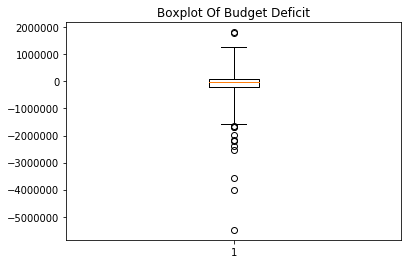

In [164]:
plt.boxplot(budget_deficit, whis = 5)
plt.title("Boxplot Of Budget Deficit")

In [165]:
# There are outliers both above and below the boxplot, so budget_deficit must be winsorized.

In [166]:
winsorized_budget = winsorize(budget_deficit, (0.05, 0.05))

Text(0.5, 1.0, 'Boxplot Of Budget Deficit')

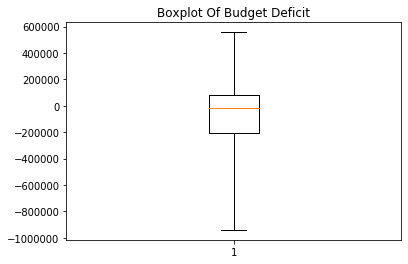

In [167]:
plt.boxplot(winsorized_budget, whis = 5)
plt.title("Boxplot Of Budget Deficit")

In [168]:
# It looks like the outliers have been eliminated.

# 4) Now create another variable by subtracting the TOTAL_EXPENDITURE from TOTAL_REVENUE. This time, use the outlier eliminated versions of TOTAL_EXPENDITURE from TOTAL_REVENUE. In this newly created variable, can you find any outliers? If so, eliminate them.

In [169]:
budget_deficit2 = winsorized_revenue - winsorized_expenditure

Text(0.5, 1.0, 'Boxplot Of Budget Deficit 2')

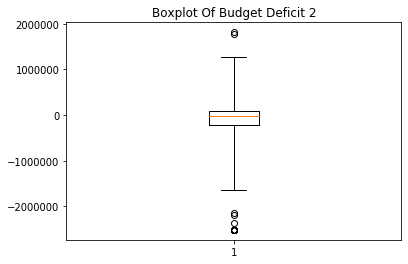

In [170]:
plt.boxplot(budget_deficit2, whis = 5)
plt.title("Boxplot Of Budget Deficit 2")

In [171]:
# The boxplot has outliers, so they must be eliminated.

In [172]:
winsorized_budget2 = winsorize(budget_deficit2, (0.05, 0.05))

Text(0.5, 1.0, 'Boxplot Of Budget Deficit 2')

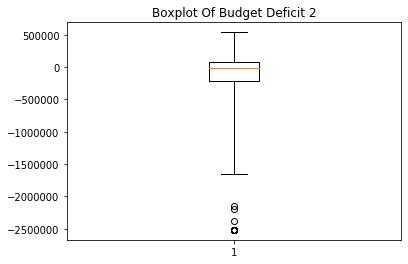

In [173]:
plt.boxplot(winsorized_budget2, whis = 5)
plt.title("Boxplot Of Budget Deficit 2")

In [174]:
# Many of the outliers were successfully eliminated. If the lower bound of the winsorization is increased, the remaining 
# few ones would also be eliminated. However, for consistency with the analysis, the values are kept winsorizing with 5% 
# acting as the threshold percentiles at both of the ends.

# 5) Compare some basic descriptive statistics of the budget variables you end up with in the 3rd and 4th questions. Do you see any differences?

In [175]:
pd.DataFrame({"original_budget": budget_deficit, "winsorized_budget1": winsorized_budget, 
              "winsorized_budget2": winsorized_budget2}).describe()

,original_budget,winsorized_budget1,winsorized_budget2
count,4.150000e+02,415.000000,4.150000e+02
mean,-1.068615e+05,-72818.787952,-1.826707e+05
std,6.013278e+05,344518.255998,6.487242e+05
min,-5.487742e+06,-940187.000000,-2.518429e+06
25%,-2.043990e+05,-204399.000000,-2.140815e+05
50%,-1.455000e+04,-14550.000000,-1.575500e+04
75%,8.363100e+04,83631.000000,8.250600e+04
max,1.816932e+06,557170.000000,5.400550e+05


In [176]:
# The two variables differ a lot for almost all critical statistics. For example, the mean of the first variant is about 
# -72818.79 whereas the mean of the second variant is about -182671; the median of the first variant is -14550.0 whereas 
# the median of the second variant is -15755.0; and the maximum of the first variant is 557170 whereas the maximum of the 
# second variant is 540055. The differences imply that choosing the outlier elimination strategy is very important as it 
# greatly affects the statistics of the variables.

# 6) If our variable of interest is the budget deficit variable, which method do you think is the appropriate in dealing with the outliers in this variable: the method in the 3rd question or the one in the 4th question?

In [177]:
# Sometimes differencing might aid in eliminating the outliers. Therefore, it's better to create a variable from the originals 
# first and then to apply outlier elimination tecniques. Thus, the approach in the third question is more appealing in most 
# of the cases.